## This time i oversample + research optimal optimiser (adam) and loss functions

In [1]:
#imports
import time
start_time = time.time()
import numpy as np
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten
from keras.metrics import binary_accuracy
#from keras.utils import np_utils
print("--- %s seconds ---" % (time.time() - start_time))

Using TensorFlow backend.


--- 5.664812088012695 seconds ---


In [2]:
# import datasets with time taken!
#smoll
""" # commented out to save computation
start_time = time.time()
smoll = np.loadtxt("/home/willett/NeutrinoData/small_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(smoll.shape)
"""

#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/full_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)


""" # commented out to save computation
#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/test_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)
"""

# extract title
pls = open("/home/willett/NeutrinoData/small_CNN_input_processed.txt", "r")
title = pls.readline()
title = title[2:-1]
print(title)



--- 2.172835111618042 seconds ---
(46280, 21)
 FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M  FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  Energy_As  Angle_Bet  Distance_Bet   Sig   Bg


In [3]:
# creating a dataset switch, change what UsedData is to change CNN
UD = fll # Used Data = <dataset>
UDLength = UD.shape[0]
print("shape: ",UD.shape,"\nsize: ", UD.size," \nlength: ", UDLength)

# dataset is expected in this format:
# FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M
#FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  
#Energy_As  Angle_Bet  Distance_Bet   Sig   Bg

# with Sig and Bg expected as one hot vectors.

shape:  (46280, 21) 
size:  971880  
length:  46280


In [4]:
# splitting X = dataset , Y = one hot vectors
X = UD[:,0:-2]
Y = UD[:,-2:1000]
print("X shape: ",X.shape,"\nY shape: ", Y.shape)

# they will be split into testing and training at compile

X shape:  (46280, 19) 
Y shape:  (46280, 2)


In [14]:
# this is a convolutional network so data must be spacially relevant: i.e. columns must be swapped.
# Convolution kernel size = (2,)

#swapping PID angle and PID front for high energy so two charge related variables in one convolution
PIDAH = X[:,5]
PIDFH = X[:,6]
X[:,5:7] = np.column_stack((PIDFH,PIDAH))

#swapping PID angle and PID front for low energy so two charge related variables in one convolution
PIDAL = X[:,13]
PIDFL = X[:,14]
X[:,13:15] =  np.column_stack((PIDFL,PIDAL))

#swapping Energy Asymetry and Distance so two geometric related variables in one convolution
# While simultaneously padding with zeros!
EAS = X[:,16]
DB = X[:,-1]
print(EAS[0],DB[0])
X2 = np.zeros((UDLength,20))
X2[:,0:-1] = X
X2[:,16] = DB
X2[:,18] = EAS

#To debug print X before and X2 after, see if they swap

0.0006966362622778047 0.6264844828458389


In [6]:
# inevitable bias removal... by oversampling
# using a 50% oversampling ratio, because i want to ! (no citation)

SigI = np.where(Y[:,0] == 1)[0] 
BgI= np.where(Y[:,0] == 0)[0]
SigN = SigI.size       # how much signal there is
BgN = BgI.size         # how much background there is
Multip = int(BgN/SigN) # how much more signal event copies needed for ~50%
print(" signal and background event number: ",SigI.size,BgI.size,"\n number more needed:",Multip)
SNratio =  (100*SigN)/(SigN + BgN)
print("initial Signal to Noise ratio: ",SNratio,"%")

#im going to reconstruct the arrays of signal events, background events, then add them together and shuffle!

XSig = X[SigI]
XBg = X[BgI]
YSig = Y[SigI]
YBg = Y[BgI]
print(XSig.shape,XBg.shape, YSig.shape, YBg.shape) # these are the events of each type.

# this is the array of signal repreated (tiled) multip times.
YSigM = np.transpose(np.tile(np.transpose(YSig), Multip))
XSigM = np.transpose(np.tile(np.transpose(XSig), Multip)) 
print( XSigM.shape, YSigM.shape)

#adding arrays together and then shuffling:
X2 = np.concatenate((XBg,XSigM))
Y2 = np.concatenate((YBg,YSigM))
print(X2.shape, Y2.shape)

#shuffling
print(X2[0:3,0],Y2[0:3,0])
np.random.shuffle(X2)
np.random.shuffle(Y2)
print(X2[0:3,0],Y2[0:3,0])

#final ratio:
NewSigN = YSigM.shape[0]
SNRatioNew = (100*YSigM.shape[0]) / (YSigM.shape[0] + BgN)
print("final Signal Noise ratio: ",SNRatioNew,"%")




 signal and background event number:  1148 45132 
 number more needed: 39
initial Signal to Noise ratio:  2.4805531547104582 %
(1148, 19) (45132, 19) (1148, 2) (45132, 2)
(44772, 19) (44772, 2)
(89904, 19) (89904, 2)
[0.00829848 0.0039091  0.00049919] [0. 0. 0.]
[0.0006866  0.00018328 0.00023447] [1. 1. 1.]
final Signal Noise ratio:  49.799786438868125 %


In [7]:
X2 = np.expand_dims(X2, axis=2) # i.e. reshape (569, 30) to (569, 30, 1) for convolution 

In [8]:
# set variables:
InDim = (X2.shape[1],X2.shape[2])       #input dimension
Fltr = 6                                #dimensionality of output space
KD = 2                                  # kernel size
Width = 12                               # width of dense layers ~ 0.75 input initially
DR = 0.5                                # rate of dropout


# linear model with a convolutional and 3 (?) dense layers.
Model = Sequential() 

Model.add(Conv1D(Fltr,   KD  , input_shape=InDim  , activation="sigmoid", use_bias=True  )) #conv
Model.add(Flatten())
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #1
Model.add(Dropout(DR) )
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #2
Model.add(Dropout(DR) )
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #3
Model.add(Dropout(DR) )

#ooh
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #4!
Model.add(Dropout(DR) )
#aah!

Model.add(Dense(2, activation="softmax", use_bias=True)) # output layer

In [9]:
# compile model:

# For a binary classification problem
Model.compile(optimizer='adam',            # adam is best for me according to https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
              loss='binary_crossentropy',  #binary_crossentropy is the best according to https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
              metrics=['accuracy', 'binary_accuracy' ])

In [12]:
# Trainining

# Train the model, iterating on the data in batches of 32 samples
history = Model.fit(X2,              # the (now oversampled) dataset
          Y2,                        #true or false values for the dataset 
          epochs=50,                 #number of iteration over data
          batch_size=32,             #number of trainings between tests
          verbose=1,                 #prints one line per epoch of progress bar
          validation_split=0.1 )     #ratio of test to train

Train on 80913 samples, validate on 8991 samples
Epoch 1/50
80913/80913 [==============================] - 18s 224us/step - loss: 0.6932 - acc: 0.4994 - binary_accuracy: 0.4994 - val_loss: 0.6933 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 2/50
80913/80913 [==============================] - 17s 214us/step - loss: 0.6932 - acc: 0.5014 - binary_accuracy: 0.5014 - val_loss: 0.6932 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 3/50
80913/80913 [==============================] - 17s 216us/step - loss: 0.6932 - acc: 0.4998 - binary_accuracy: 0.4998 - val_loss: 0.6932 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 4/50
80913/80913 [==============================] - 17s 213us/step - loss: 0.6932 - acc: 0.5017 - binary_accuracy: 0.5017 - val_loss: 0.6931 - val_acc: 0.5038 - val_binary_accuracy: 0.5038
Epoch 5/50
80913/80913 [==============================] - 18s 220us/step - loss: 0.6932 - acc: 0.5001 - binary_accuracy: 0.5001 - val_loss: 0.6931 - val_acc: 0.5038 - val_

80913/80913 [==============================] - 18s 228us/step - loss: 0.6932 - acc: 0.4982 - binary_accuracy: 0.4982 - val_loss: 0.6932 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 43/50
80913/80913 [==============================] - 18s 223us/step - loss: 0.6932 - acc: 0.5021 - binary_accuracy: 0.5021 - val_loss: 0.6932 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 44/50
80913/80913 [==============================] - 18s 221us/step - loss: 0.6932 - acc: 0.4994 - binary_accuracy: 0.4994 - val_loss: 0.6934 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 45/50
80913/80913 [==============================] - 18s 225us/step - loss: 0.6932 - acc: 0.5037 - binary_accuracy: 0.5037 - val_loss: 0.6932 - val_acc: 0.5038 - val_binary_accuracy: 0.5038
Epoch 46/50
80913/80913 [==============================] - 18s 224us/step - loss: 0.6932 - acc: 0.5017 - binary_accuracy: 0.5017 - val_loss: 0.6932 - val_acc: 0.4962 - val_binary_accuracy: 0.4962
Epoch 47/50
80913/80913 [=======

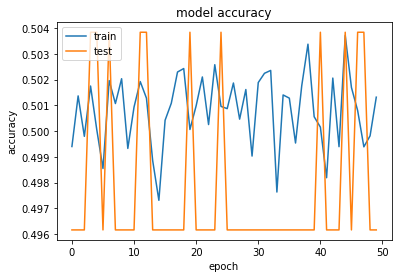

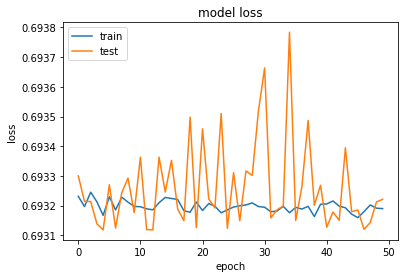

In [13]:
#summarise history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Cant even overfit the data!